In [89]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [44]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [45]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
'PlantVillage',
shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size =  BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [46]:
class_names = dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [47]:
len(dataset) 

68

In [48]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 2, 0, 0, 0, 1, 0])>>


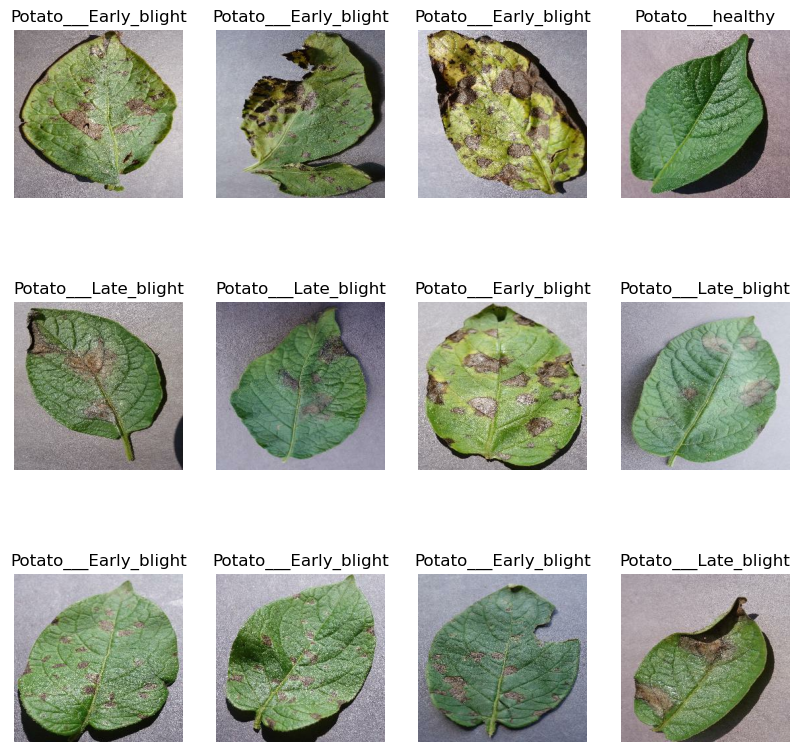

In [49]:

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):  
        ax = plt.subplot(3,4,1+i)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])  
        plt.axis("off")



#splitting our dataset
#use 80% of data as training data

80% ==> training
20% ==> 10% validation, 10% test


In [50]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [51]:
train_size = 0.8
len(dataset) * train_size

54

In [52]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [53]:
 val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [54]:
 val_size = 0.1
len(dataset) * val_size

6

In [55]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [56]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1,shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds,test_ds

In [57]:
get_dataset_partitions_tf(dataset)

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [58]:
len(train_ds)

54

In [59]:
len(test_ds)

8

In [60]:
len(val_ds)

6

In [61]:
#caching to improve the performance of the model
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [62]:
#Scaling
resize_and_rescale = tf.keras.Sequential([
     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [63]:
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [64]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])
model.build(input_shape = input_shape)

In [65]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_8 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_26 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_26 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [69]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'])

In [70]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds)

Epoch 1/50

54/54 [==============================] - 94s 2s/step - loss: 0.9082 - accuracy: 0.5064 - val_loss: 0.7569 - val_accuracy: 0.6198
Epoch 2/50
54/54 [==============================] - 67s 1s/step - loss: 0.6908 - accuracy: 0.6806 - val_loss: 0.6146 - val_accuracy: 0.7448
Epoch 3/50
54/54 [==============================] - 61s 1s/step - loss: 0.4517 - accuracy: 0.8009 - val_loss: 0.7129 - val_accuracy: 0.6667
Epoch 4/50
54/54 [==============================] - 61s 1s/step - loss: 0.3135 - accuracy: 0.8657 - val_loss: 0.1519 - val_accuracy: 0.9323
Epoch 5/50
54/54 [==============================] - 69s 1s/step - loss: 0.2653 - accuracy: 0.8900 - val_loss: 0.2469 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 75s 1s/step - loss: 0.1700 - accuracy: 0.9317 - val_loss: 0.2173 - val_accuracy: 0.9219
Epoch 7/50
54/54 [==============================] - 69s 1s/step - loss: 0.1101 - accuracy: 0.9612 - val_loss: 0.3810 - val_accuracy: 0.8906
Epoch 8/50
54/54 [=

In [71]:
 #how the model scores on the test dataset
    scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 212ms/step - loss: 0.0943 - accuracy: 0.9784


In [72]:
scores

[0.09432315826416016, 0.9784482717514038]

In [73]:
history

In [74]:
scores

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [75]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [76]:
history.history['accuracy']

[0.5063657164573669,
 0.6805555820465088,
 0.8009259104728699,
 0.8657407164573669,
 0.8900462985038757,
 0.9317129850387573,
 0.9612268805503845,
 0.9415509104728699,
 0.9635416865348816,
 0.9681712985038757,
 0.9658564925193787,
 0.9699074029922485,
 0.9571759104728699,
 0.9594907164573669,
 0.9594907164573669,
 0.9716435074806213,
 0.9762731194496155,
 0.9855324029922485,
 0.9450231194496155,
 0.9849537014961243,
 0.9855324029922485,
 0.9837962985038757,
 0.9866898059844971,
 0.9855324029922485,
 0.9797453880310059,
 0.9739583134651184,
 0.9803240895271301,
 0.9820601940155029,
 0.9913194179534912,
 0.9907407164573669,
 0.9774305820465088,
 0.9809027910232544,
 0.9820601940155029,
 0.984375,
 0.9866898059844971,
 0.9936342835426331,
 0.9930555820465088,
 0.9878472089767456,
 0.9907407164573669,
 0.9959490895271301,
 0.9878472089767456,
 0.9895833134651184,
 0.9918981194496155,
 0.9832175970077515,
 0.9913194179534912,
 0.9924768805503845,
 0.9907407164573669,
 0.9855324029922485,
 0

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

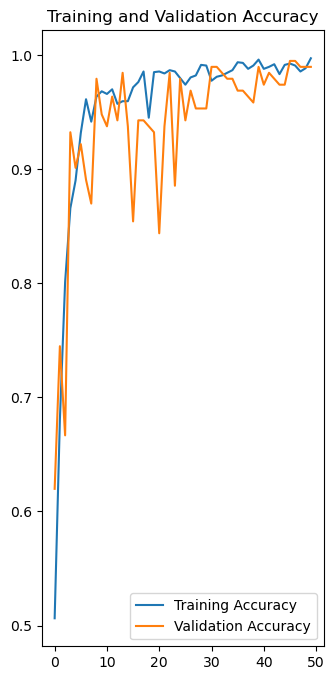

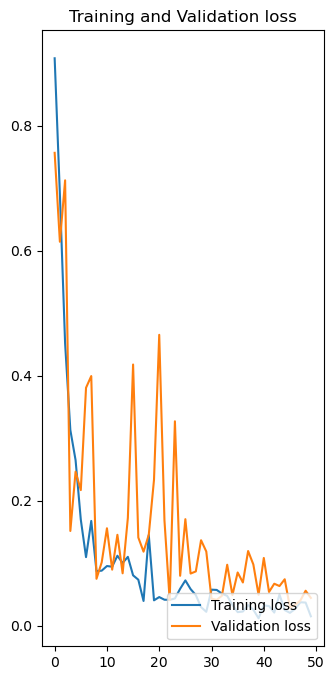

In [120]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label= 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label= 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label= 'Training loss')a
plt.plot(range(EPOCHS), val_loss, label= 'Validation loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation loss')


plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 220ms/step
[9.238156e-10 2.701616e-04 9.997298e-01]
predicted label: Potato___healthy


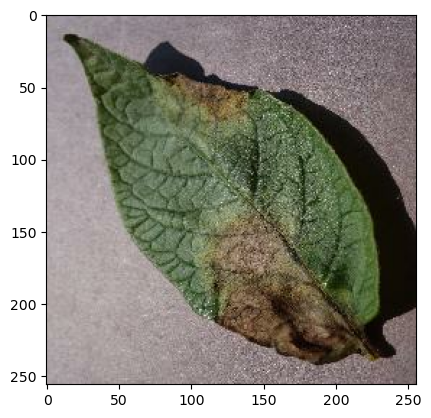

In [135]:
import numpy as np

for images_batch,labels_batch in test_ds.take(1):
    
    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0].numpy()
print( "first image to predict")
plt.imshow(first_image)
print( "actual label:", class_names[first_label])
batch_prediction =  model.predict(image_batch)
print(batch_prediction[0])
print("predicted label:", class_names[np.argmax(batch_prediction[0])])


In [146]:
def predict (model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create batch
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

                                                    

1/1 [==============================] - 0s 33ms/step


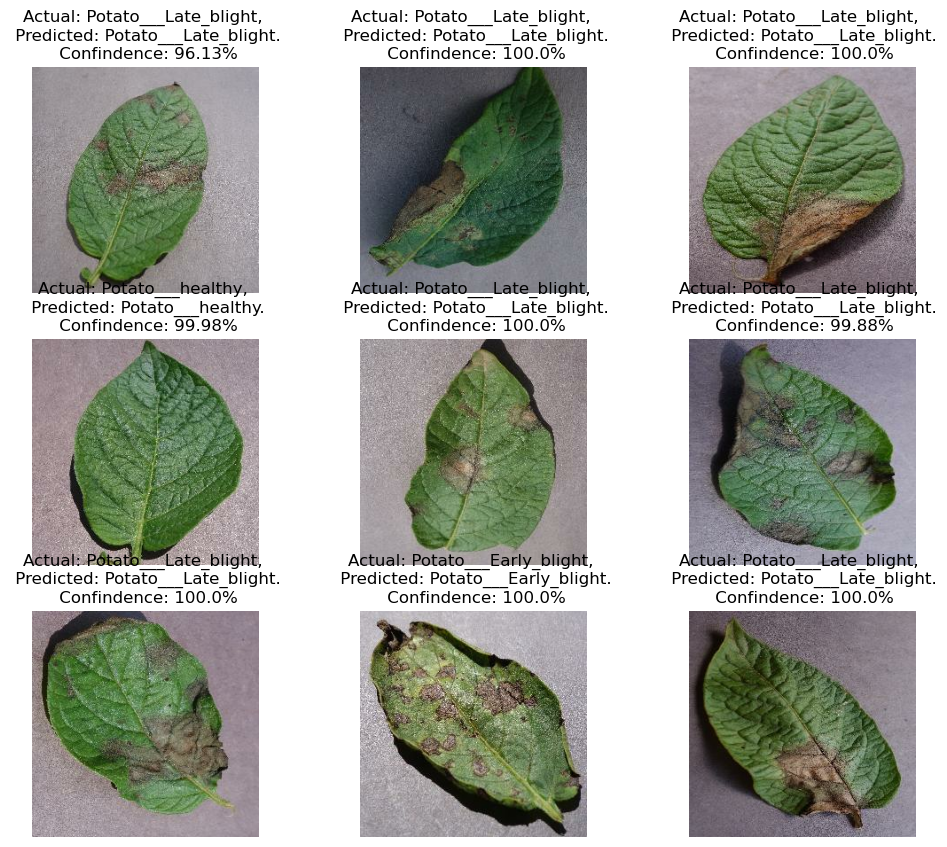

In [149]:
plt.figure(figsize = (12,10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint"))
        predicted_class,confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.axis("off")

        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confindence: {confidence}%")

In [152]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
